In [2]:
import pandas as pd 
import process
import numpy as np 

# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

In [8]:
import warnings

################## PARAMETERS #################################################################
lookback_window = [0, 250]
number_of_clusters = 20
sigma = 10e-1
clustering_method = 'signed_laplacian' 
number_of_repetition = 10
evaluation_window = 10
eta=0.01
###############################################################################################

warnings.filterwarnings('ignore')

PnL = []
overall_return = pd.DataFrame()
portfolio_value =[1]

consolidated_W_1 = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta)
portoflio_return_1 = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W_1)

lookback_window_1 = [lookback_window[0] + evaluation_window, lookback_window[1] + evaluation_window]

consolidated_W_2 = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window_1, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta)
portoflio_return_2 = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window_1, consolidated_W=consolidated_W_2)

overall_return_2 = pd.concat([portoflio_return_1, portoflio_return_2])

In [18]:
overall_return_2 = pd.concat([portoflio_return_1, portoflio_return_2])
overall_return_2

,portfolio return
28/12/2000,0.005122
29/12/2000,0.003264
02/01/2001,0.006295
03/01/2001,0.005760
04/01/2001,0.000583
05/01/2001,0.001651
08/01/2001,0.006117
09/01/2001,0.001775
10/01/2001,0.002641
11/01/2001,0.000067


In [13]:
import warnings 


warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window = [0, 250]
number_of_clusters = 20
sigma = 10e-1
clustering_method = 'signed_laplacian' 
number_of_repetition = 10
evaluation_window = 7
eta=0.01
PnL = []
overall_return = pd.DataFrame()
portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period

for i in range(1, 30):

    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, evaluation_window=evaluation_window, eta=eta, clustering_method=clustering_method)

    portfolio_return = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W)

    overall_return = pd.concat([overall_return, portfolio_return])

    lookback_window = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

    PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + portfolio_return)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après
    
    portfolio_value.append(portfolio_value[-1]+PnL[-1])

    print(portfolio_value[-1])
    
    print(f'step {i}')

1.0298424328441391
step1
1.0415384282772726
step2
1.0530325761072954
step3
1.0611557288935138
step4
1.0674673051770396
step5
1.073752652944645
step6
1.0783828930392463
step7
1.0725132854313946
step8
1.084665172063927
step9
1.0918721547599133
step10
1.0756689762135392
step11
1.0801474374500968
step12
1.0788013573073203
step13
1.0751477564095169
step14
1.0777187440197975
step15
1.0573579461295703
step16
1.0562941098112777
step17
1.0630005951620891
step18
1.0481085176968565
step19
1.0556022766914102
step20
1.0619663367435452
step21
1.0665963932482219
step22
1.0825364061913898
step23
1.0470777818616717
step24
1.0611157312525965
step25
1.0548420078767267
step26
1.048991974914037
step27
1.0404553303667754
step28
1.0421217533527898
step29


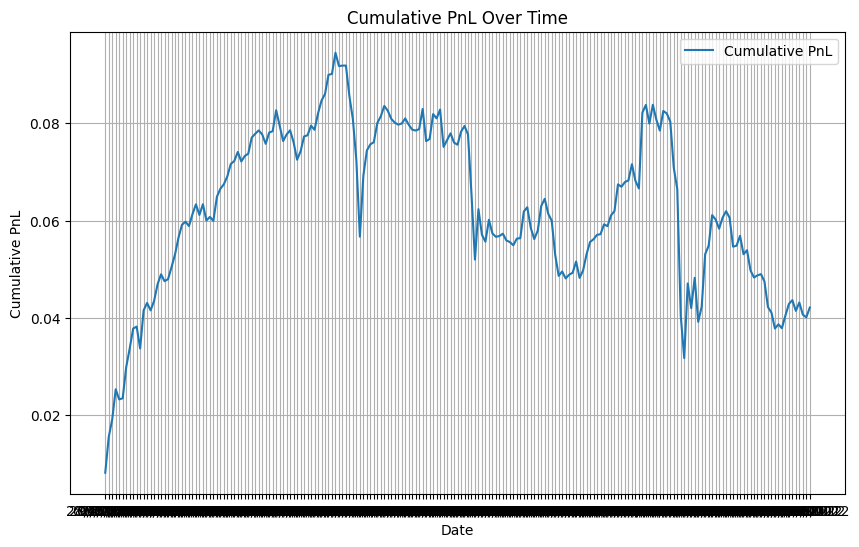

In [14]:
cumulative_PnL = (1 + overall_return).cumprod() - 1

import matplotlib.pyplot as plt


# Tracez le PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(cumulative_PnL, label='Cumulative PnL')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

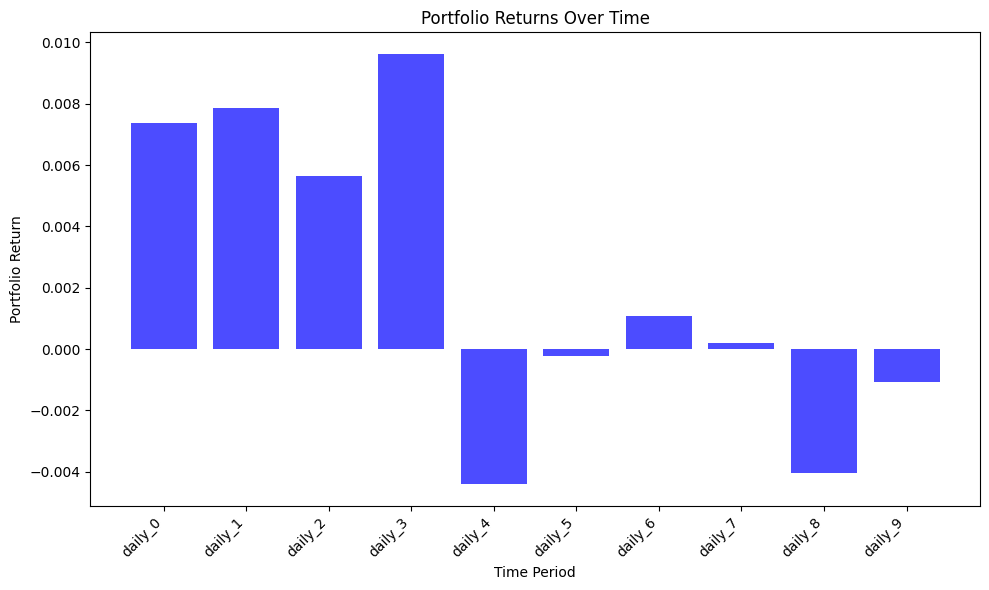

In [8]:
process.bar_plot_PnL(PnL)
